# Description
One of our primary objectives is to prepare the data for future use by maximizing available information and minimizing nulls and missing values. Several challenges contribute to this, including:

 - Varying formats across different years
 - Inconsistent column names
 - Different header rows
 - Missing ticker information
 - Absent industry data
 - Incomplete or inaccurate Scope 3 data

 We can overcome much of this by working the issues through one by one and then refactoring the code into a class definition that can produce data objects suitable for the user's needs.

  The raw CDP data comes in 11 very large cumbersome excel files that can be difficult to work with.  As such, it is best to use Python to index through them and concatenate worksheets into dataframes with common column names, dropping unneeded columns.

In [3]:
import os
import glob
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
# Define the folder containing the Excel files
folder_path = r'C:\Users\cliff\OneDrive\Documents\Data Practicum1\CDP_Data'  



# Pull all Summary sheets
The cell below indexes through all files in the folder looking for the Summary Data sheet and concatenates them into one dataframe.  It is a starting point but does not address the various formats of the headers that occur over different years.  Also below we can attempt to speed up the process using ThreadPoolExecutor which can allow Python to do several jobs in parallel though I did not do any processing speed tests to see if this actually helps.

In [5]:

def process_excel_files(folder_path):
    """
    Process Excel files in the specified folder (non-recursive) and extract data from the 'Summary Data' sheet.
    The function prints the number of files pulled, the number of unique 'account_id' values, and the number of
    unique 'incorporated_country' values, then returns a concatenated DataFrame containing the data.

    Args:
        folder_path (str): The path to the folder containing the Excel files.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with data from the 'Summary Data' sheet.
    """
    # Get all Excel files directly in the specified folder (non-recursive)
    excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
    
    def process_file(file):
        print(f"Processing file: {os.path.basename(file)}")
        try:
            # Create an ExcelFile object to inspect sheet names
            xls = pd.ExcelFile(file)
            if 'Summary Data' in xls.sheet_names:
                # Read the 'Summary Data' sheet ensuring 'account_id' is read as a string
                df = pd.read_excel(xls, sheet_name='Summary Data', dtype={'account_id': str})
                # Add a column to track the source file name
                df['source_file'] = os.path.basename(file)
                return df
            else:
                print(f"Worksheet 'Summary Data' not found in {os.path.basename(file)}")
        except Exception as e:
            print(f"Error processing {os.path.basename(file)}: {e}")
        return None

    dataframes = []
    # Use ThreadPoolExecutor to process files concurrently
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, file) for file in excel_files]
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                dataframes.append(result)
    
    # Concatenate all dataframes into one large dataframe if any were found
    if dataframes:
        final_df = pd.concat(dataframes, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    # Compute statistics
    files_pulled = len(dataframes)
    unique_account_ids = final_df['account_id'].nunique() if not final_df.empty else 0
    unique_account_numbers = final_df['Account number'].nunique() if not final_df.empty else 0
    
    unique_ticker = final_df['ticker'].nunique() if not final_df.empty else 0
    unique_Tickers = final_df['Tickers'].nunique() if not final_df.empty else 0
    unique_Primary_Ticker = final_df['Primary Ticker'].nunique() if not final_df.empty else 0
    
    
    unique_countries = final_df['incorporated_country'].nunique() if not final_df.empty and 'incorporated_country' in final_df.columns else 0

    # Print statistics
    print(f"Number of files pulled: {files_pulled}")
    print(f"Number of unique account_id values: {unique_account_ids}")
    print(f"Number of unique unique_account_numbers: {unique_account_numbers}")

    print(f"Number of unique unique_ticker values: {unique_ticker}")
    print(f"Number of unique unique_Tickers values: {unique_Tickers}")
    print(f"Number of unique unique_Primary_Ticker values: {unique_Primary_Ticker}")
    
    
    print(f"Number of unique incorporated_country values: {unique_countries}")

    return final_df

full_df = process_excel_files(folder_path)



Processing file: 2013 Public Climate Change Data.xlsx
Processing file: 2014 Public Climate Change Data.xlsx
Processing file: 2015 Public Climate Change Data.xlsx
Processing file: 2016 Public Climate Change Data.xlsx
Processing file: 2017 Public Climate Change Data.xlsx
Processing file: 2018 Public Climate Change Data.xlsx
Processing file: 2019 Public Climate Change Data.xlsx
Processing file: 2020 Public Climate Change Data.xlsx
Processing file: 2021 Public Climate Change Data.xlsx
Processing file: 2022 Public Climate Change Data.xlsx
Processing file: 2023 Public Climate Change Data_v3.xlsx
Number of files pulled: 11
Number of unique account_id values: 7154
Number of unique unique_account_numbers: 15873
Number of unique unique_ticker values: 3091
Number of unique unique_Tickers values: 4259
Number of unique unique_Primary_Ticker values: 3267
Number of unique incorporated_country values: 100


In [6]:
full_df.head()

,program_name,account_id,account_name,region,incorporated_country,Access,GRI,secondary_expansion,ticker,source_file,Account number,Organization,Country,Region,Public,Samples,Primary activity,Primary sector,Primary industry,Primary questionnaire sector,Tickers,Authority types,Country/Area,Request response status,Access type,Response received date,Activities,Sectors,Industries,Primary Ticker,Primary ISIN
0,Climate Change,44,3i Group,United Kingdom,United Kingdom,Public,"Banks, Diverse Financials, Insurance","FTSE 600,FTSE 725,FTSE 350",III LN,2013 Public Climate Change Data.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Supply Chain,45,7COMM INFORMATICA LTDA,South America,Brazil,Public,Software & Services,NaN,NaN,2013 Public Climate Change Data.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Climate Change,53,Abertis Infraestructuras,Southern Europe,Spain,Public,Ground Transportation - Highways & Railtracks,"FTSE All-World,Euro,Iberia,Spain",ABE SM,2013 Public Climate Change Data.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Supply Chain,55,Amway Corporation,USA,USA,Public,"Consumer Durables, Household and Personal Prod...",NaN,NaN,2013 Public Climate Change Data.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Supply Chain,58,ABM INDUSTRIES INC,USA,USA,Public,Trading Companies & Distributors and Commercia...,NaN,ABM US,2013 Public Climate Change Data.xlsx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing industry Visualization

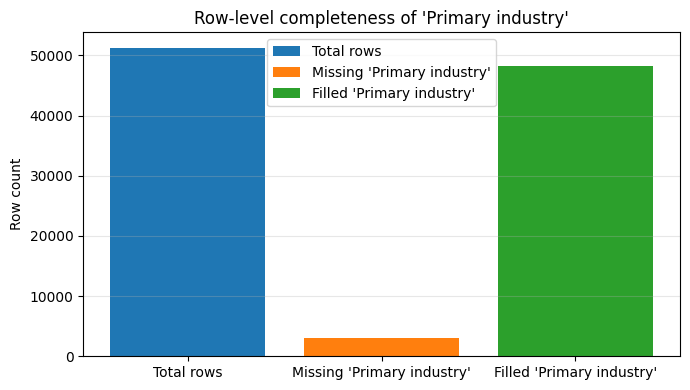

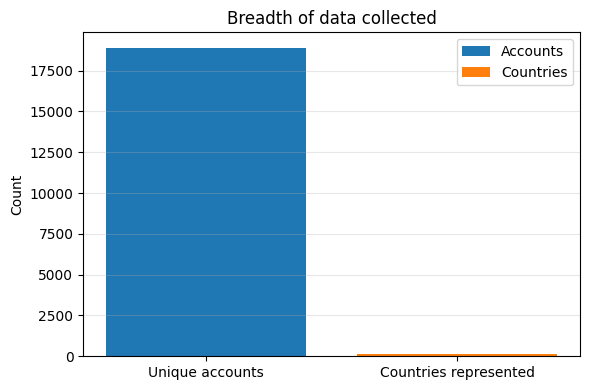

In [8]:
import matplotlib.pyplot as plt

# Numbers provided in the logs
total_rows = 51263
missing_primary_industry = 3028
filled_primary_industry = total_rows - missing_primary_industry

unique_accounts = 18898
unique_countries = 147

# 1. Primary‑industry completeness
fig1, ax1 = plt.subplots(figsize=(7, 4))
ax1.bar(["Total rows"], [total_rows], label="Total rows")
ax1.bar(["Missing 'Primary industry'"], [missing_primary_industry], label="Missing 'Primary industry'")
ax1.bar(["Filled 'Primary industry'"], [filled_primary_industry], label="Filled 'Primary industry'")
ax1.set_ylabel("Row count")
ax1.set_title("Row‑level completeness of 'Primary industry'")
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

plt.tight_layout()
plt.show()

# 2. Coverage of accounts & countries
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.bar(["Unique accounts"], [unique_accounts], label="Accounts")
ax2.bar(["Countries represented"], [unique_countries], label="Countries")
ax2.set_ylabel("Count")
ax2.set_title("Breadth of data collected")
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


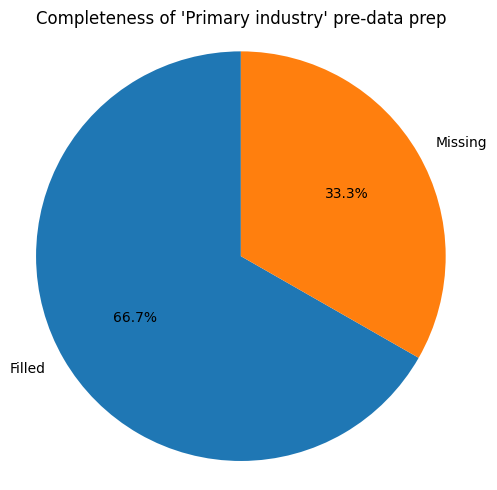

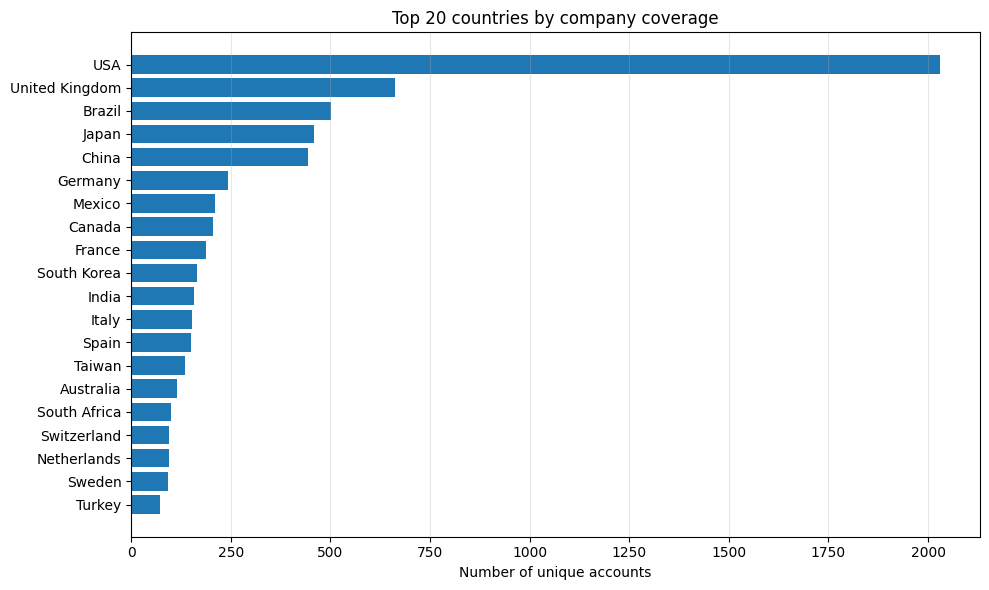

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Safety check: make sure the dataframe is available ---
if 'full_df' not in globals():
    raise NameError(
        "The DataFrame 'full_df' is not defined in the current kernel. "
        "Run the data‑loading cell (process_excel_files) first."
    )

# -----------------------------------------------------------
# 1) Pie chart – completeness of ‘Primary industry’
# -----------------------------------------------------------
total_rows = len(full_df)
missing_primary = full_df['Primary industry'].isna().sum()
filled_primary = total_rows - missing_primary

labels = ['Filled', 'Missing']
sizes = [filled_primary, missing_primary]

fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
ax1.set_title("Completeness of 'Primary industry' pre-data prep")
ax1.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.tight_layout()

# -----------------------------------------------------------
# 2) Bar chart – top‑20 countries by unique accounts
# -----------------------------------------------------------
country_counts = (
    full_df.groupby('incorporated_country')['account_id']
           .nunique()
           .dropna()
           .sort_values(ascending=False)
           .head(20)
)

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.barh(country_counts.index[::-1], country_counts.values[::-1])  # reverse for largest on top
ax2.set_xlabel("Number of unique accounts")
ax2.set_title("Top 20 countries by company coverage")
ax2.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()


# Access all account Numbers
 
 Below we take it a few steps forward.  The worksheets are concatenated but also like columns that are named differently are merged together.  Additionally, we can use the merged 'Account Numbers' column to create dictionaries for industry, sector, activity and ticker values.  These dictionaries can then be used to back fill any 'Account Number' values that are missing theses values.

In [11]:
import os
import glob
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_excel_files(folder_path):
    """
    Process Excel files in the specified folder (non-recursive) and extract data from the 'Summary Data' sheet.
    The function:
        - Adds a 'reporting_year' column extracted from the first 4 characters of the file name.
        - Prints statistics on the number of files pulled, unique 'account_id' values, and unique 'incorporated_country' values.
        - Merges columns:
            * 'account_id' (2013-2017) and 'Account number' (2018-2023) into 'Account Numbers'
            * 'region' and 'Region' into 'Region'
            * 'incorporated_country', 'Country', and 'Country/Area' into 'Country'
            * 'Access', 'Access type', and 'Public' into 'Access'
            * 'Organization' and 'account_name' into 'Company Name'
            * 'ticker' and 'Tickers' into 'Stock Ticker'
        - Creates a dictionary mapping non-null 'Account Numbers' (as strings) to 'Primary industry'
          (only for rows where 'Primary industry' is not null)
        - Backfills any null 'Primary industry' values using that dictionary.
    
    Args:
        folder_path (str): The path to the folder containing the Excel files.

    Returns:
        tuple: (pandas.DataFrame, dict) The processed DataFrame and the industry dictionary.
    """
    # Get all Excel files directly in the specified folder (non-recursive)
    excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
    
    def process_file(file):
        print(f"Processing file: {os.path.basename(file)}")
        try:
            xls = pd.ExcelFile(file)
            if 'Summary Data' in xls.sheet_names:
                # Read the 'Summary Data' sheet ensuring 'account_id' is read as a string
                df = pd.read_excel(xls, sheet_name='Summary Data', dtype={'account_id': str, 'Account number': str})
                # Add a column for the source file name
                df['source_file'] = os.path.basename(file)
                # Add a column for the reporting year (first four characters of the file name)
                df['reporting_year'] = os.path.basename(file)[:4]
                return df
            else:
                print(f"Worksheet 'Summary Data' not found in {os.path.basename(file)}")
        except Exception as e:
            print(f"Error processing {os.path.basename(file)}: {e}")
        return None

    dataframes = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, file) for file in excel_files]
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                dataframes.append(result)
    
    # Concatenate all dataframes if any were successfully processed
    final_df = pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

    # Compute and print basic statistics
    files_pulled = len(dataframes)

    print(f"Number of files pulled: {files_pulled}")



    # Helper function to merge columns: takes the first non-null value among the candidate columns
    def merge_columns(df, new_col, candidates):
        merged = pd.Series([pd.NA] * len(df))
        for col in candidates:
            if col in df.columns:
                merged = merged.fillna(df[col])
        # Ensure the merged column is a string
        df[new_col] = merged.astype(str)
        # Drop the original candidate columns if they exist
        df.drop(columns=[col for col in candidates if col in df.columns], inplace=True)
        return df

    # Merge the specified columns into unified columns
    final_df = merge_columns(final_df, 'Account Numbers', ['account_id', 'Account number'])
    final_df = merge_columns(final_df, 'Regions', ['region', 'Region'])
    final_df = merge_columns(final_df, 'Countries', ['incorporated_country', 'Country', 'Country/Area'])
    final_df = merge_columns(final_df, 'Access Types', ['Access', 'Access type', 'Public'])
    final_df = merge_columns(final_df, 'Market Indices', ['secondary_expansion', 'Samples type']) #CDP uses Market Cap from major indices and other environmental factors to help determine who should be requested to respond
    final_df = merge_columns(final_df, 'Company Name', ['Organization', 'account_name'])
    final_df = merge_columns(final_df, 'Primary Stock Ticker', ['ticker', 'Primary Ticker']) #these contain the primary stock tickers while 'tickers' is a list of all ticker possibilities
    
    # Identify rows where 'Primary Stock Ticker' is null and 'Tickers' is not null
    mask = final_df['Primary Stock Ticker'].isna() & final_df['Tickers'].notna()
    
    # For these rows, split the 'Tickers' string by comma, take the first element, and remove extra whitespace
    final_df.loc[mask, 'Primary Stock Ticker'] = final_df.loc[mask, 'Tickers'].str.split(',').str[0].str.strip()

    final_df['Primary Stock Ticker'] = final_df['Primary Stock Ticker'].replace('nan', np.nan)

    # Ensure that 'Account Numbers' is of string type
    final_df['Account Numbers'] = final_df['Account Numbers'].astype(str)

    # Optional: If empty strings might be interfering, convert them to NA in 'Primary industry'
    if 'Primary industry' in final_df.columns:
        final_df['Primary industry'] = final_df['Primary industry'].replace('', pd.NA)

    
    # Create a dictionary mapping non-null 'Account Numbers' to 'Primary industry'
    industry_dict = {}
    if not final_df.empty and 'Primary industry' in final_df.columns:
        # Only consider rows where both 'Account Numbers' and 'Primary industry' are non-null
        valid_rows = final_df.loc[
            final_df['Account Numbers'].notna() & final_df['Primary industry'].notna()
        ]
        # Group by 'Account Numbers' and take the first non-null 'Primary industry' per group
        industry_dict = valid_rows.groupby('Account Numbers')['Primary industry'].first().to_dict()
        
        # Backfill null 'Primary industry' values using the dictionary
        final_df.loc[
            final_df['Primary industry'].isna(), 'Primary industry'
        ] = final_df.loc[
            final_df['Primary industry'].isna(), 'Account Numbers'
        ].map(industry_dict)
    
    # Create a dictionary mapping non-null 'Account Numbers' to 'Primary sector'
    sector_dict = {}
    if not final_df.empty and 'Primary sector' in final_df.columns:
        # Only consider rows where both 'Account Numbers' and 'Primary sector' are non-null
        valid_rows = final_df.loc[
            final_df['Account Numbers'].notna() & final_df['Primary sector'].notna()
        ]
        # Group by 'Account Numbers' and take the first non-null 'Primary sector' per group
        sector_dict = valid_rows.groupby('Account Numbers')['Primary sector'].first().to_dict()
        
        # Backfill null 'Primary sector' values using the dictionary
        final_df.loc[
            final_df['Primary sector'].isna(), 'Primary sector'
        ] = final_df.loc[
            final_df['Primary sector'].isna(), 'Account Numbers'
        ].map(sector_dict)

    # Create a dictionary mapping non-null 'Account Numbers' to 'Primary activity'
    activity_dict = {}
    if not final_df.empty and 'Primary activity' in final_df.columns:
        # Only consider rows where both 'Account Numbers' and 'Primary activity' are non-null
        valid_rows = final_df.loc[
            final_df['Account Numbers'].notna() & final_df['Primary activity'].notna()
        ]
        # Group by 'Account Numbers' and take the first non-null 'Primary activity' per group
        activity_dict = valid_rows.groupby('Account Numbers')['Primary activity'].first().to_dict()
        
        # Backfill null 'Primary activity' values using the dictionary
        final_df.loc[
            final_df['Primary activity'].isna(), 'Primary activity'
        ] = final_df.loc[
            final_df['Primary activity'].isna(), 'Account Numbers'
        ].map(activity_dict)

    # Create a dictionary mapping non-null 'Account Numbers' to 'Primary Stock Ticker'
    ticker_dict = {}
    if not final_df.empty and 'Primary Stock Ticker' in final_df.columns:
        # Only consider rows where both 'Account Numbers' and 'Primary activity' are non-null
        valid_rows = final_df.loc[
            final_df['Account Numbers'].notna() & final_df['Primary Stock Ticker'].notna()
        ]
        # Group by 'Account Numbers' and take the first non-null 'Primary Stock Ticker' per group
        ticker_dict = valid_rows.groupby('Account Numbers')['Primary Stock Ticker'].first().to_dict()
        
        # Backfill null 'Primary Stock Ticker' values using the dictionary
        final_df.loc[
            final_df['Primary Stock Ticker'].isna(), 'Primary Stock Ticker'] = final_df.loc[
            final_df['Primary Stock Ticker'].isna(), 'Account Numbers'].map(ticker_dict)
        

    
    return final_df



merged_df =  process_excel_files(folder_path)


unique_account_numbers = merged_df['Account Numbers'].nunique() if not merged_df.empty else 0
unique_countries = (merged_df['Countries'].nunique() 
                    if not merged_df.empty and 'Countries' in merged_df.columns 
                    else 0)



print(f"Number of unique Account Numbers values: {unique_account_numbers}")
print(f"Number of unique incorporated_country values: {unique_countries}")

unique_null_count = merged_df.loc[merged_df['Primary industry'].isna(), 'Account Numbers'].nunique()
print("Unique Account Numbers with null Primary industry:", unique_null_count)

unique_null_count = merged_df.loc[merged_df['Primary sector'].isna(), 'Account Numbers'].nunique()
print("Unique Account Numbers with null Primary sector:", unique_null_count)

unique_null_count = merged_df.loc[merged_df['Primary activity'].isna(), 'Account Numbers'].nunique()
print("Unique Account Numbers with null Primary activity:", unique_null_count)




unique_Primary_Stock_Ticker = merged_df['Primary Stock Ticker'].nunique() if not merged_df.empty else 0



print(f"Number of unique unique_Primary_Stock_Ticker values: {unique_Primary_Stock_Ticker}")

merged_df['Primary Stock Ticker'] = merged_df['Primary Stock Ticker'].replace('nan', np.nan)


print(f"Number of null Primary_Stock_Ticker values: {merged_df['Primary Stock Ticker'].isna().sum()}")

print(f"Total number of rows in dataframe: {len(merged_df)}")

Processing file: 2013 Public Climate Change Data.xlsx
Processing file: 2014 Public Climate Change Data.xlsx
Processing file: 2015 Public Climate Change Data.xlsx
Processing file: 2016 Public Climate Change Data.xlsx
Processing file: 2017 Public Climate Change Data.xlsx
Processing file: 2018 Public Climate Change Data.xlsx
Processing file: 2019 Public Climate Change Data.xlsx
Processing file: 2020 Public Climate Change Data.xlsx
Processing file: 2021 Public Climate Change Data.xlsx
Processing file: 2022 Public Climate Change Data.xlsx
Processing file: 2023 Public Climate Change Data_v3.xlsx
Number of files pulled: 11
Number of unique Account Numbers values: 19279
Number of unique incorporated_country values: 149
Unique Account Numbers with null Primary industry: 3409
Unique Account Numbers with null Primary sector: 3409
Unique Account Numbers with null Primary activity: 3409
Number of unique unique_Primary_Stock_Ticker values: 4623
Number of null Primary_Stock_Ticker values: 27908
Total

# Missing Data Check
 Above we can see that even after backfilling using the dictionaries there are still 3409 missing industry, sector and activity rows.  In the Practicum I effort those were lumped together as 'Unknown' but we can improve upon that here.  Most of the missing values come from the 2013-2017 data which uses a single 'GRI' column to give industry information rather than split it into separate Industry, Sector, Activity columns as in the later years.  Since there are 52 unique values in 'GRI' and 15 in 'Primary Industry', 64 in 'Primary Sector' and 222 in 'Primary Activity' we can use AI to help us (ie do most of the work) build a dictionary that can convert each unique GRI value into the most appropriate Industry, Sectory and Activity values which we can then review for correctness.

In [13]:
unique_values = merged_df['Primary sector'].unique()
print("Number of unique values in 'Primary sector':", len(unique_values))
print("Unique values in 'Primary sector':", unique_values)



Number of unique values in 'Primary sector': 64
Unique values in 'Primary sector': ['Financial services' 'IT & software development' 'Construction' nan
 'Commercial & consumer services' 'Medical equipment & supplies'
 'Specialized professional services' 'Thermal power generation'
 'Wood & paper materials' 'Cement & concrete'
 'Electrical & electronic equipment' 'Bars, hotels & restaurants'
 'Metal smelting, refining & forming' 'Industrial support services'
 'Chemicals' 'Web & marketing services' 'Convenience retail'
 'Marine transport' 'Discretionary retail' 'Energy utility networks'
 'Metallic mineral mining' 'Other services'
 'Trading, wholesale, distribution, rental & leasing'
 'Food & beverage processing' 'Air transport' 'Biotech & pharma'
 'Intermodal transport & logistics' 'Print & publishing services'
 'Tobacco' 'Transportation equipment' 'Plastic product manufacturing'
 'Leisure & home manufacturing' 'Metal products manufacturing'
 'Oil & gas extraction & production' 'Other min

In [14]:
unique_values = merged_df['Primary industry'].unique()
print("Number of unique values in 'Primary industry':", len(unique_values))
print("Unique values in 'Primary industry':", unique_values)

Number of unique values in 'Primary industry': 15
Unique values in 'Primary industry': ['Services' 'Infrastructure' nan 'Biotech, health care & pharma'
 'Power generation' 'Materials' 'Manufacturing' 'Hospitality' 'Retail'
 'Transportation services' 'Food, beverage & agriculture' 'Fossil Fuels'
 'Apparel' 'International bodies' 'Corporate Tags']


In [15]:
unique_values = merged_df['Primary activity'].unique()
print("Number of unique values in 'Primary activity':", len(unique_values))
print("Unique values in 'Primary activity':", unique_values)

Number of unique values in 'Primary activity': 222
Unique values in 'Primary activity': ['Asset managers' 'Software'
 'Transportation infrastructure & other construction' nan
 'Commercial services' 'Health care supplies'
 'Other professional services' 'CCGT generation' 'Pulp & paper mills'
 'Banks' 'Cement' 'Electronic components' 'Hotels & lodging'
 'Iron & steel' 'Transportation support services' 'Insurance'
 'Communications equipment' 'Specialty chemicals' 'Marketing'
 'Supermarkets, food & drugstores' 'Marine freight' 'Electrical equipment'
 'Apparel stores' 'Electricity networks'
 'Precious metals & minerals mining' 'Health care services'
 'Iron ore mining' 'Vehicles & machinery rental & leasing'
 'Medical equipment' 'Other food processing' 'Passenger airlines'
 'Inorganic base chemicals' 'Aluminium refining' 'Pharmaceuticals'
 'Logistics - transport' 'Print publishing' 'Tobacco products'
 'IT services' 'Railroad rolling stock' 'REIT' 'Plastic products'
 'Sporting goods' 'Alcoholi

In [16]:
unique_values = merged_df['GRI'].dropna().unique()
print("Number of unique values in 'GRI':", len(unique_values))
print("Unique values in 'GRI':", unique_values)

Number of unique values in 'GRI': 52
Unique values in 'GRI': ['Banks, Diverse Financials, Insurance' 'Software & Services'
 'Ground Transportation - Highways & Railtracks'
 'Consumer Durables, Household and Personal Products'
 'Trading Companies & Distributors and Commercial Services & Supplies'
 'Healthcare Providers & Services, and Healthcare Technology'
 'Professional Services'
 'Electric Utilities & Independent Power Producers & Energy Traders (including fossil, alternative and nuclear energy)'
 'Forest and Paper Products - Forestry, Timber, Pulp and Paper, Rubber'
 'Construction Materials' 'Technology Hardware & Equipment'
 'Hotels, Restaurants & Leisure, and Tourism Services'
 'Mining - Iron, Aluminum, Other Metals'
 'Air Transportation - Airport Services'
 'Pharmaceuticals, Biotechnology & Life Sciences'
 'Semiconductors & Semiconductors Equipment' 'Chemicals'
 'Construction & Engineering' 'Media' 'Food & Staples Retailing'
 'Water Transportation - Water Transportation'
 'Electr

# GRI Mapping Dictionary

In [18]:
# GRI mapping dictionary


gri_mapping = {
    "Banks, Diverse Financials, Insurance": {
        "Primary industry": "Services",
        "Primary sector": "Financial services",
        "Primary activity": "Banks"
    },
    "Software & Services": {
        "Primary industry": "Services",
        "Primary sector": "IT & software development",
        "Primary activity": "Software"
    },
    "Ground Transportation - Highways & Railtracks": {
        "Primary industry": "Transportation services",
        "Primary sector": "Road transport",   
        "Primary activity": "Bus & taxi"  # Or 'Road freight' / 'Logistics - transport' etc., depending on your data
    },
    "Consumer Durables, Household and Personal Products": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Light manufacturing",
        "Primary activity": "Personal care & household products"
    },
    "Trading Companies & Distributors and Commercial Services & Supplies": {
        "Primary industry": "Services",
        "Primary sector": "Trading, wholesale, distribution, rental & leasing",
        "Primary activity": "Dealers, wholesalers & distributors"
    },
       "Banks, Diverse Financials, Insurance": {
        "Primary industry": "Services",
        "Primary sector": "Financial services",
        "Primary activity": "Banks"
    },

    "Healthcare Providers & Services, and Healthcare Technology": {
        "Primary industry": "Biotech, health care & pharma",
        "Primary sector": "Health care provision",
        "Primary activity": "Health care services"
    },

    "Professional Services": {
        "Primary industry": "Services",
        "Primary sector": "Specialized professional services",
        "Primary activity": "Other professional services"
    },

    #    (including fossil, alternative and nuclear energy)
    "Electric Utilities & Independent Power Producers & Energy Traders (including fossil, alternative and nuclear energy)": {
        "Primary industry": "Power generation",
        "Primary sector": "Energy utility networks",
        "Primary activity": "Electricity networks"
    },

    "Forest and Paper Products - Forestry, Timber, Pulp and Paper, Rubber": {
        "Primary industry": "Materials",
        "Primary sector": "Wood & paper materials",
        "Primary activity": "Pulp & paper mills"
    },

    "Construction Materials": {
        "Primary industry": "Materials",
        "Primary sector": "Cement & concrete",
        "Primary activity": "Cement"
    },

    "Technology Hardware & Equipment": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Electrical & electronic equipment",
        "Primary activity": "Computer hardware"
    },

    "Hotels, Restaurants & Leisure, and Tourism Services": {
        "Primary industry": "Hospitality",
        "Primary sector": "Bars, hotels & restaurants",
        "Primary activity": "Hotels & lodging"
    },

    "Mining - Iron, Aluminum, Other Metals": {
        "Primary industry": "Materials",
        "Primary sector": "Metallic mineral mining",
        "Primary activity": "Metal smelting, refining & forming"
    },

    "Air Transportation - Airport Services": {
        "Primary industry": "Transportation services",
        "Primary sector": "Air transport",
        "Primary activity": "Airport services"
    },

    "Pharmaceuticals, Biotechnology & Life Sciences": {
        "Primary industry": "Biotech, health care & pharma",
        "Primary sector": "Biotech & pharma",
        "Primary activity": "Pharmaceuticals"
    },

    "Semiconductors & Semiconductors Equipment": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Electrical & electronic equipment",
        "Primary activity": "Semiconductors"
    },

    "Chemicals": {
        "Primary industry": "Materials",
        "Primary sector": "Chemicals",
        "Primary activity": "Specialty chemicals"
    },

    "Construction & Engineering": {
        "Primary industry": "Infrastructure",
        "Primary sector": "Construction",
        "Primary activity": "Engineering services"
    },

    "Media": {
        "Primary industry": "Services",
        "Primary sector": "Media, telecommunications & data center services",
        "Primary activity": "Media"
    },

    "Food & Staples Retailing": {
        "Primary industry": "Retail",
        "Primary sector": "Convenience retail",
        "Primary activity": "Supermarkets, food & drugstores"
    },

    "Water Transportation - Water Transportation": {
        "Primary industry": "Transportation services",
        "Primary sector": "Marine transport",
        "Primary activity": "Marine freight"
    },

    "Electrical Equipment and Machinery": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Electrical & electronic equipment",
        "Primary activity": "Electrical equipment"
    },


    "Retailing": {
        "Primary industry": "Retail",
        "Primary sector": "Discretionary retail",
        "Primary activity": "Specialist retail"
    },

    "Mining - Other (Precious Metals and Gems)": {
        "Primary industry": "Materials",
        "Primary sector": "Metallic mineral mining",
        "Primary activity": "Precious metals & minerals mining"
    },

    "Food & Beverage Processing": {
        "Primary industry": "Food, beverage & agriculture",
        "Primary sector": "Food & beverage processing",
        "Primary activity": "Other food processing"
    },

    "Air Transportation - Airlines": {
        "Primary industry": "Transportation services",
        "Primary sector": "Air transport",
        "Primary activity": "Passenger airlines"
    },

    "Ground Transportation - Railroads Transportation": {
        "Primary industry": "Transportation services",
        "Primary sector": "Rail transport",
        "Primary activity": "Rail freight"
        # (Could also be "Passenger rail" if most of the data is passenger-focused)
    },

    "Tobacco": {
        "Primary industry": "Food, beverage & agriculture",
        "Primary sector": "Tobacco",
        "Primary activity": "Tobacco products"
    },

    "Telecommunication Services": {
        "Primary industry": "Services",
        "Primary sector": "Media, telecommunications & data center services",
        "Primary activity": "Telecommunications services"
    },

    # 5) Real Estate
    "Real Estate": {
        "Primary industry": "Infrastructure",
        "Primary sector": "Land & property ownership & development",
        "Primary activity": "Real estate owners & developers"
        # Adjust as needed if your data focuses on REITs, property services, etc.
    },

    "Containers & Packaging": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Paper products & packaging",
        "Primary activity": "Metal containers & packaging"
        # Or "Other containers & packaging" if that’s a better fit
    },

    "Oil & Gas": {
        "Primary industry": "Fossil Fuels",
        "Primary sector": "Oil & gas extraction & production",
        "Primary activity": "Oil & gas extraction"
        # Adjust if your data focuses on refining, pipelines, etc.
    },

    "Gas Utilities": {
        "Primary industry": "Fossil Fuels",
        "Primary sector": "Gas utilities",
        "Primary activity": "Gas utilities"
    },

    # 9) Mining - Coal
    "Mining - Coal": {
        "Primary industry": "Materials",
        "Primary sector": "Coal mining",
        "Primary activity": "Coal extraction & processing"
    },

    "Building Products": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Building products",
        "Primary activity": "Other building products"
        # Could refine to "Concrete products", "Ceramics", etc. if needed
    },

    "Textiles, Apparel, Footwear and Luxury Goods": {
        "Primary industry": "Apparel",
        "Primary sector": "Apparel design",
        "Primary activity": "Apparel & footwear"
    },

    "Aerospace & Defense": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Transportation equipment",
        "Primary activity": "Aerospace"
        # If data includes defense contractors could refine further
    },

    "Automobiles & Components": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Transportation equipment",
        "Primary activity": "Automobiles"
    },

    "Home building": {
        "Primary industry": "Infrastructure",
        "Primary sector": "Construction",
        "Primary activity": "Residential building construction"
    },

    "Air Freight transportation and Logistics": {
        "Primary industry": "Transportation services",
        "Primary sector": "Air transport",
        "Primary activity": "Air freight"
    },

    "Water Transportation - Ports & Services": {
        "Primary industry": "Transportation services",
        "Primary sector": "Marine transport",
        "Primary activity": "Ports & services"
    },

    "Water Utilities": {
        "Primary industry": "Infrastructure",
        "Primary sector": "Non-energy utilities",
        "Primary activity": "Water supply networks"
    },

    "Specialized Consumer Services": {
        "Primary industry": "Services",
        "Primary sector": "Consumer services",
        "Primary activity": "Consumer services"
        # Adjust if there's a more specific option in your data
    },


    "Ground Transportation - Trucking Transportation": {
        "Primary industry": "Transportation services",
        "Primary sector": "Road transport",
        "Primary activity": "Road freight"
    },

    "Public Agencies": {
        "Primary industry": "International bodies",
        "Primary sector": "Government bodies",
        "Primary activity": "Public agencies"
        # Or if you have a special classification for them, adjust accordingly
    },

    "Food Production - Agricultural Production": {
        "Primary industry": "Food, beverage & agriculture",
        "Primary sector": "Crop farming",
        "Primary activity": "Crop farming"
    },

    "Tires": {
        "Primary industry": "Manufacturing",
        "Primary sector": "Wood & rubber products",
        "Primary activity": "Rubber products"
    },

    "Healthcare Equipment & Supplies": {
        "Primary industry": "Biotech, health care & pharma",
        "Primary sector": "Medical equipment & supplies",
        "Primary activity": "Medical equipment"
    },

    "Education Services": {
        "Primary industry": "Services",
        "Primary sector": "Education services",
        "Primary activity": "Education services"
    },

    "Solid Waste Management Utilities": {
        "Primary industry": "Infrastructure",
        "Primary sector": "Non-energy utilities",
        "Primary activity": "Waste management"
    },

    "Food Production - Meat, Poultry, Fishery": {
        "Primary industry": "Food, beverage & agriculture",
        "Primary sector": "Food & beverage processing",
        "Primary activity": "Animal processing"
    },

    "NGO": {
        "Primary industry": "International bodies",
        "Primary sector": "Other services",
        "Primary activity": "NGO"
    },

}


# Utilize GRI_mappig
A visual check through the AI-produced GRI_mapping shows that they are fairly appropriate matchups.  Now use the gri_mapping to fill in missing industry data.

In [20]:
def fill_from_gri(row, gri_dict):
    """
    For a single row, if GRI is in gri_dict, fill in missing columns with the mapping.
  
    gri_dict: the dictionary mapping GRI -> {Primary industry, Primary sector, Primary activity}
    """
    if row['GRI'] in gri_dict:
        mapping = gri_dict[row['GRI']]
        
        # Fill Primary industry
        if pd.isna(row['Primary industry']):
            row['Primary industry'] = mapping['Primary industry']
        
        # Fill Primary sector
        if pd.isna(row['Primary sector']):
            row['Primary sector'] = mapping['Primary sector']
        
        # Fill Primary activity
        if pd.isna(row['Primary activity']):
            row['Primary activity'] = mapping['Primary activity']
    
    return row

# Apply the fill_from_gri function to each row
merged_df = merged_df.apply(lambda r: fill_from_gri(r, gri_mapping), axis=1)


# Missing Data Check
Now check for any entries that are still missing industry data.  Below we can see that we have gone from 3409 missing entries to 3 which all appear to have missing GRI values to use for mapping.

In [22]:
null_gri_rows = merged_df[merged_df['Primary industry'].isna()]
null_gri_rows.head()


,program_name,GRI,source_file,reporting_year,Samples,Primary activity,Primary sector,Primary industry,Primary questionnaire sector,Tickers,Authority types,Request response status,Response received date,Activities,Sectors,Industries,Primary ISIN,Account Numbers,Regions,Countries,Access Types,Market Indices,Company Name,Primary Stock Ticker
18435,NaN,NaN,2018 Public Climate Change Data.xlsx,2018,NaN,NaN,NaN,NaN,General,ELT NO,Supply Chain,NaN,NaN,NaN,NaN,NaN,NaN,5408,nan,Norway,public,nan,Eltek AS,ELT NO
19841,NaN,NaN,2018 Public Climate Change Data.xlsx,2018,"Agriculture, Environmental",NaN,NaN,NaN,"Food, beverage & tobacco",GMCR US,"Investor, Supply Chain",NaN,NaN,NaN,NaN,NaN,NaN,40297,nan,United States of America,public,nan,Keurig Green Mountain,GMCR US
20628,NaN,NaN,2018 Public Climate Change Data.xlsx,2018,Self selected companies climate change,NaN,NaN,NaN,Transport services,"1518971D US, 1518971DUS",Investor,NaN,NaN,NaN,NaN,NaN,NaN,831380,nan,United States of America,public,nan,Northwest Seaport Alliance,NaN


# Manual Mapping
To fill in these last three missing industry values I looked up the main websites of these companies and filled out custom mappings according to the industry, sector and main activity they appeared to fit in to.

In [24]:
eltek_mapping = {
    "Primary industry": "Power generation",
    "Primary sector": "Energy utility networks",
    "Primary activity": "Industrial power systems"
}

# Create a condition for rows where Company Name is "Eltek AS"
condition = merged_df['Company Name'] == "Eltek AS"

# Option 1: Overwrite the values unconditionally
merged_df.loc[condition, 'Primary industry'] = eltek_mapping["Primary industry"]
merged_df.loc[condition, 'Primary sector'] = eltek_mapping["Primary sector"]
merged_df.loc[condition, 'Primary activity'] = eltek_mapping["Primary activity"]

keurig_mapping = {
    "Primary industry": "Food, beverage & agriculture",
    "Primary sector": "Food & beverage processing",
    "Primary activity": "Specialty coffee systems"
}

# Create a condition to select rows where the 'Company Name' is 'Keurig Green Mountain'
condition = merged_df['Company Name'] == "Keurig Green Mountain"

# Option 1: Overwrite the values unconditionally for the matching rows
merged_df.loc[condition, 'Primary industry'] = keurig_mapping["Primary industry"]
merged_df.loc[condition, 'Primary sector'] = keurig_mapping["Primary sector"]
merged_df.loc[condition, 'Primary activity'] = keurig_mapping["Primary activity"]

nws_mapping = {
    "Primary industry": "Transportation services",
    "Primary sector": "Marine transport",
    "Primary activity": "Port operations"
}

# Create a condition to select rows where the 'Company Name' is 'Northwest Seaport Alliance'
condition = merged_df['Company Name'] == "Northwest Seaport Alliance"

# Option 1: Overwrite the values unconditionally for the matching rows
merged_df.loc[condition, 'Primary industry'] = nws_mapping["Primary industry"]
merged_df.loc[condition, 'Primary sector'] = nws_mapping["Primary sector"]
merged_df.loc[condition, 'Primary activity'] = nws_mapping["Primary activity"]


# Data Check

A quick check below shows no null values left for industry, sector and activity.

In [26]:
unique_null_count = merged_df.loc[merged_df['Primary industry'].isna(), 'Account Numbers'].nunique()
print("Unique Account Numbers with null Primary industry:", unique_null_count)

unique_null_count = merged_df.loc[merged_df['Primary sector'].isna(), 'Account Numbers'].nunique()
print("Unique Account Numbers with null Primary sector:", unique_null_count)

unique_null_count = merged_df.loc[merged_df['Primary activity'].isna(), 'Account Numbers'].nunique()
print("Unique Account Numbers with null Primary activity:", unique_null_count)

Unique Account Numbers with null Primary industry: 0
Unique Account Numbers with null Primary sector: 0
Unique Account Numbers with null Primary activity: 0


# Drop Unneeded columns

Now to drop some unneeded columns and reorder columns for easier use.

In [28]:
merged_df2 = merged_df.copy()
columns_to_drop = ['GRI', 'Industries', 'Sectors', 'Activities', 'source_file', 'Primary questionnaire sector', 'Request response status','Response received date', 'Primary ISIN', 'Access Types']  #dropping redundant columns in last two years of data

for col in columns_to_drop:
    if col in merged_df2.columns:
        merged_df2.drop(col, axis=1, inplace=True)


# Define the desired order for the specified columns
cols_order = ['Account Numbers', 'reporting_year', 'Company Name', 'Primary Stock Ticker', 'Countries', 
              'Regions', 'Primary industry', 'Primary sector', 'Primary activity']

# Create a list of desired columns that exist in merged_df2
existing_cols = [col for col in cols_order if col in merged_df2.columns]

# Identify the remaining columns that aren't in the desired list
remaining_cols = [col for col in merged_df2.columns if col not in existing_cols]

# Reorder the DataFrame columns so that the existing desired ones come first
merged_df2 = merged_df2[existing_cols + remaining_cols]


In [29]:
merged_df2.head()

,Account Numbers,reporting_year,Company Name,Primary Stock Ticker,Countries,Regions,Primary industry,Primary sector,Primary activity,program_name,Samples,Tickers,Authority types,Market Indices
0,44,2013,3i Group,III LN,United Kingdom,United Kingdom,Services,Financial services,Asset managers,Climate Change,NaN,NaN,NaN,"FTSE 600,FTSE 725,FTSE 350"
1,45,2013,7COMM INFORMATICA LTDA,NaN,Brazil,South America,Services,IT & software development,Software,Supply Chain,NaN,NaN,NaN,nan
2,53,2013,Abertis Infraestructuras,ABE SM,Spain,Southern Europe,Infrastructure,Construction,Transportation infrastructure & other construc...,Climate Change,NaN,NaN,NaN,"FTSE All-World,Euro,Iberia,Spain"
3,55,2013,Amway Corporation,NaN,USA,USA,Manufacturing,Light manufacturing,Personal care & household products,Supply Chain,NaN,NaN,NaN,nan
4,58,2013,ABM INDUSTRIES INC,ABM US,USA,USA,Services,Commercial & consumer services,Commercial services,Supply Chain,NaN,NaN,NaN,nan


# Store Data in Dictionary

Since this is the summary data we won't actually be using this data for analysis but will store it as a dictionary to fill in any blanks in the actual GHG data.  We can use the 'Account Numbers' and the 'reporting_year' as the keys in the dictionary.  We can also save this as a JSON file for later use without having to go through this process again.

In [31]:
import json
from collections import defaultdict

# Create nested dictionary 
account_dict = defaultdict(dict)
for _, row in merged_df2.iterrows():
    account = row['Account Numbers']
    reporting_year = row['reporting_year']
    row_data = row.drop(labels=['Account Numbers', 'reporting_year']).to_dict()
    account_dict[account][reporting_year] = row_data

# Convert defaultdict to a regular dict 
account_dict = dict(account_dict)

# Save the dictionary as a JSON file with UTF-8-SIG encoding
output_path = r'C:\Users\cliff\OneDrive\Documents\Data Practicum1\CDP_Data\Corporate_Data\account_dictionary.json'
with open(output_path, 'w', encoding='utf-8-sig') as f:
    json.dump(account_dict, f, ensure_ascii=False, indent=4)

print(f"JSON file saved to: {output_path}")



JSON file saved to: C:\Users\cliff\OneDrive\Documents\Data Practicum1\CDP_Data\Corporate_Data\account_dictionary.json


# delete dictionary to free up memory 

Now that we have saved the dictionary to a json we can refer to that later.  As such, we can delete the merged_df2 dataframe to free up memory.

In [33]:
del merged_df2
import gc
gc.collect()


0

# Pull Main Scope 3 Data

Now to pull the main Scope 3 data.  This data is in different worksheets over the various years, it uses the same basic structure for the data in terms of columns but the column headers are worded differently in different years.  Additionally, the header rows are different in the last two years.  As above we will merge columns that are the same but have different headings.

In [35]:

import os
import glob
import re
import pandas as pd
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed

def merge_columns(df, new_col, candidates, force_str=False):
    """
    Merges specified columns into a single column by taking the first non-null value.
    Drops the original columns once merged.
    """
    if not df.empty:
        merged = pd.Series(pd.NA, dtype="object", index=df.index)
        for col in candidates:
            if col in df.columns:
                merged = merged.combine_first(df[col])

        df[new_col] = merged
        
        # Convert to string only if needed
        if force_str:
            df[new_col] = df[new_col].astype(str).replace("<NA>", pd.NA)
        
        # Drop original columns that were merged
        df.drop(columns=[col for col in candidates if col in df.columns], inplace=True, errors='ignore')
    return df

def process_file(file, search_terms):
    """
    Reads a single Excel file, finds a worksheet whose name contains any term in search_terms,
    extracts it (with a header adjustment based on year in filename), and returns a DataFrame.
    """
    file_name = os.path.basename(file)
    # Attempt to extract a 4-digit year
    year_match = re.search(r'(\d{4})', file_name)
    year = year_match.group(1) if year_match else "Unknown"
    
    # Adjust header row based on year
    header_row = 1 if year in ["2022", "2023"] else 0

    try:
        xls = pd.ExcelFile(file)
        # Find the first matching sheet
        matching_sheet = next(
            (sheet for sheet in xls.sheet_names if any(term in sheet for term in search_terms)),
            None
        )
        if matching_sheet:
            df = pd.read_excel(xls, sheet_name=matching_sheet, header=header_row)
            df['Source File'] = file_name
            df['Year'] = year
            df['Year of Data'] = year
            return df
        else:
            print(f"No matching worksheet found in: {file_name}")
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
    
    return None

def merge_chunk_data(chunk_data):
    """
    Given a list of DataFrames from one chunk, concatenate them and merge key columns.
    Returns the chunk's merged DataFrame.
    """
    if not chunk_data:
        return pd.DataFrame()

    chunk_df = pd.concat(chunk_data, ignore_index=True)
    
    # Perform merges for columns of interest
    chunk_df = merge_columns(chunk_df, 'Account Numbers', ['account_id', 'Account number'], force_str=True)
    chunk_df = merge_columns(chunk_df, 'Countries', ['incorporated_country', 'Country', 'Country/Area'])
    chunk_df = merge_columns(chunk_df, 'Company Name', ['Organization', 'account_name'])
    chunk_df = merge_columns(chunk_df, 'Primary Stock Ticker', ['ticker', 'Primary Ticker','Tickers'])
    chunk_df = merge_columns(chunk_df, 'Row_num', ['row', 'Row'])
    chunk_df = merge_columns(chunk_df, 'Scope 3 Sources', [
        '14.1 C1 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Sources of Scope 3 emissions',
        'CC14.1 C1 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Sources of Scope 3 emissions',
        'RowName'])
    chunk_df = merge_columns(chunk_df, 'Evaluation Status', [
        '14.1 C2 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Evaluation status',
        'CC14.1 C2 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Evaluation status',
        'C6.5_C1_Account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions. - Evaluation status',
        'C6.5_C1_Account for your organization’s gross global Scope 3 emissions, disclosing and explaining any exclusions. - Evaluation status'])
    chunk_df = merge_columns(chunk_df, 'Scope 3 Amount', [
        '14.1 C3 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - metric tonnes CO2e',
        'CC14.1 C3 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - metric tonnes CO2e',
        'C6.5_C2_Account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions. - Metric tonnes CO2e',
        'C6.5_C2_Account for your organization’s gross global Scope 3 emissions, disclosing and explaining any exclusions. - Metric tonnes CO2e',
        'C6.5_C2_Account for your organization’s gross global Scope 3 emissions, disclosing and explaining any exclusions. - Emissions in reporting year (metric tons CO2e)'])
    chunk_df = merge_columns(chunk_df, 'Calculation Methodology', [
        '14.1 C4 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Methodology',
        'CC14.1 C4 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Emissions calculation methodology',
        'C6.5_C3_Account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions. - Emissions calculation methodology',
        'C6.5_C3_Account for your organization’s gross global Scope 3 emissions, disclosing and explaining any exclusions. - Emissions calculation methodology'])
    chunk_df = merge_columns(chunk_df, 'Perc emissions calculated w primary data ', [
        '14.1 C5 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Percentage of emissions calculated using primary data',
        'CC14.1 C5 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Percentage of emissions calculated using primary data',
        'CC14.1 C5 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Percentage of emissions calculated using data obtained from suppliers or value chain partners',
        'C6.5_C4_Account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions. - Percentage of emissions calculated using data obtained from suppliers or value chain partners',
        'C6.5_C4_Account for your organization’s gross global Scope 3 emissions, disclosing and explaining any exclusions. - Percentage of emissions calculated using data obtained from suppliers or value chain partners'])
    chunk_df = merge_columns(chunk_df, 'Explanation', [
        '14.1 C6 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Explanation',
        'CC14.1 C6 - Please account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions - Explanation',
        'C6.5_C5_Account for your organization’s Scope 3 emissions, disclosing and explaining any exclusions. - Explanation',
        'C6.5_C5_Account for your organization’s gross global Scope 3 emissions, disclosing and explaining any exclusions. - Please explain'])

    # Remove trailing ".0" from Account Numbers if present
    chunk_df['Account Numbers'] = (
        chunk_df['Account Numbers']
        .astype(str)
        .str.replace(r'\.0$', '', regex=True)
    )
    
    chunk_df['Row_num'] = (
        chunk_df['Row_num']
        .astype(str)
        .str.replace(r'\.0$', '', regex=True)
    )

    # Drop unwanted columns if they exist
    columns_to_drop = [
        'program_name', 'project_year', 'accounting_year', 'Source File', 'Year',
        'Authority types', 'Primary questionnaire sector', 'Request response status',
        'Access type', 'Samples', 'Response received date', 'Activities', 'Sectors',
        'Industries', 'Primary ISIN', 'Access Types'
    ]
    existing_cols = [c for c in columns_to_drop if c in chunk_df.columns]
    chunk_df.drop(columns=existing_cols, inplace=True, errors='ignore')

    # Define the desired order for the specified columns
    cols_order = ['Account Numbers', 'Year of Data', 'Company Name', 'Primary Stock Ticker', 'Countries', 
                 'Primary industry', 'Primary sector', 'Primary activity', 'Row_num','Scope 3 Sources', 'Scope 3 Amount', 'Evaluation Status', 'Calculation Methodology', 'Perc emissions calculated w primary data', 'Explanation']
    
    # # Create a list of desired columns that exist in merged_df2
    # existing_cols = [col for col in cols_order if col in final_df.columns]
    
    # # Identify the remaining columns that aren't in the desired list
    # remaining_cols = [col for col in final_df.columns if col not in existing_cols]

    # Run garbage collection
    gc.collect()

    return chunk_df

def extract_and_merge_data_in_batches(folder_path, search_terms, chunk_size=10):
    """
    Reads Excel files in smaller batches using concurrency to avoid memory spikes.
    Each batch is processed and merged into a single DataFrame, then appended 
    to a global list. The final DataFrame is concatenated from these chunks.
    """
    excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
    
    # Store results for each chunk
    chunked_results = []

    # Batch processing in chunks
    for i in range(0, len(excel_files), chunk_size):
        file_batch = excel_files[i : i + chunk_size]
        
        # Step 1: Concurrently process each file in this batch
        batch_data = []
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(process_file, f, search_terms) for f in file_batch]
            for future in as_completed(futures):
                df = future.result()
                if df is not None:
                    batch_data.append(df)
        
        # Step 2: Merge the chunk’s data
        if batch_data:
            chunk_df = merge_chunk_data(batch_data)
            chunked_results.append(chunk_df)
        
        # Free memory
        del batch_data
        gc.collect()

    # Concatenate all chunked results
    if not chunked_results:
        print("No data extracted from any files.")
        return pd.DataFrame()

    final_df = pd.concat(chunked_results, ignore_index=True)
    return final_df


search_terms = ["14.1", "CC14.1", "C6.5"]
chunk_size = 10  # Number of files to process at once

Scope_3_df = extract_and_merge_data_in_batches(folder_path, search_terms, chunk_size=chunk_size)






In [36]:
Scope_3_df.head()

,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation
0,2013,NaN,NaN,NaN,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...
1,2013,NaN,NaN,NaN,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...
2,2013,NaN,NaN,NaN,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not includ...,"Not relevant, explanation provided",NaN,NaN,NaN,We do not have any fuel or energy related acti...
3,2013,NaN,NaN,NaN,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",NaN,NaN,NaN,NaN
4,2013,NaN,NaN,NaN,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN


# Employ Account dictionary

This code reads a nested JSON file containing company account information organized by account ID and year, then flattens the structure into a tabular format for analysis. First, it loads the JSON file (`account_dictionary.json`) into a Python dictionary, where each key is an account ID and the value is a dictionary of yearly data. It then iterates through each account and each year, creating a flat record that includes the account ID, year, and all associated attributes. These records are compiled into a list and converted into a pandas DataFrame. Finally, it replaces any string representations of missing values like `"NaN"` or `"nan"` with proper NumPy `NaN` values to ensure compatibility for analysis.


In [38]:
import json
import pandas as pd
import numpy as np

# ---------- 1 · load the JSON exactly as you already did ----------
json_path = r"C:\Users\cliff\OneDrive\Documents\Data Practicum1\CDP_Data\Corporate_Data\account_dictionary.json"
with open(json_path, "r", encoding="utf-8-sig") as f:
    account_dict = json.load(f)

# ---------- 2 · flatten the two‑level structure ----------
records = []
for acct_id, yearly_data in account_dict.items():
    for year, attrs in yearly_data.items():
        # attrs is already a dict of the company’s attributes for that year
        rec = {"Account ID": acct_id, "Year": int(year)}
        rec.update(attrs)          # add all the attribute columns
        records.append(rec)

# ---------- 3 · build the dataframe ----------
df_accounts = pd.DataFrame.from_records(records)

# ---------- 4 · optional: ensure NaN values (if the JSON used the string "NaN") ----------
df_accounts.replace({"NaN": np.nan, "nan": np.nan}, inplace=True)

# quick peek
df_accounts.head()





,Account ID,Year,Company Name,Primary Stock Ticker,Countries,Regions,Primary industry,Primary sector,Primary activity,program_name,Samples,Tickers,Authority types,Market Indices
0,44,2013,3i Group,III LN,United Kingdom,United Kingdom,Services,Financial services,Asset managers,Climate Change,NaN,NaN,NaN,"FTSE 600,FTSE 725,FTSE 350"
1,44,2014,3i Group,III LN,United Kingdom,United Kingdom,Services,Financial services,Asset managers,Climate Change,NaN,NaN,NaN,"FTSE 600,FTSE 725,FTSE 350,FTSE 100"
2,44,2016,3i Group,III LN,United Kingdom,United Kingdom,Services,Financial services,Asset managers,Climate Change,NaN,NaN,NaN,"Benchmark,FTSE 600,FTSE 725,FTSE 350,FTSE 100"
3,44,2017,3i Group,III LN,United Kingdom,United Kingdom,Services,Financial services,Asset managers,Climate Change,NaN,NaN,NaN,"Benchmark,FTSE 600,FTSE 725,FTSE 350,FTSE 100"
4,44,2018,3i Group,III LN,United Kingdom of Great Britain and Northern I...,NaN,Services,Financial services,Asset managers,NaN,"Benchmark, Euro, FTSE 100, FTSE 350, FTSE 600...",III LN,Investor,NaN


In [39]:
df_accounts.columns

Index(['Account ID', 'Year', 'Company Name', 'Primary Stock Ticker',
       'Countries', 'Regions', 'Primary industry', 'Primary sector',
       'Primary activity', 'program_name', 'Samples', 'Tickers',
       'Authority types', 'Market Indices'],
      dtype='object')

# Visualizing Missing Key Metadata in Company Account Data

This code analyzes and visualizes the completeness of important metadata fields in a previously loaded DataFrame (`df_accounts`). It focuses on a set of key descriptive columns—such as industry, sector, country, and stock ticker—and calculates how many values are missing in each. It first confirms the DataFrame exists in the current session, then computes the number of missing values per column and the total number of rows with at least one missing key field. Two bar plots are generated: one shows missing value counts by column, and the other compares the total number of records against those with incomplete key metadata, helping identify data quality issues for further cleaning or imputation.


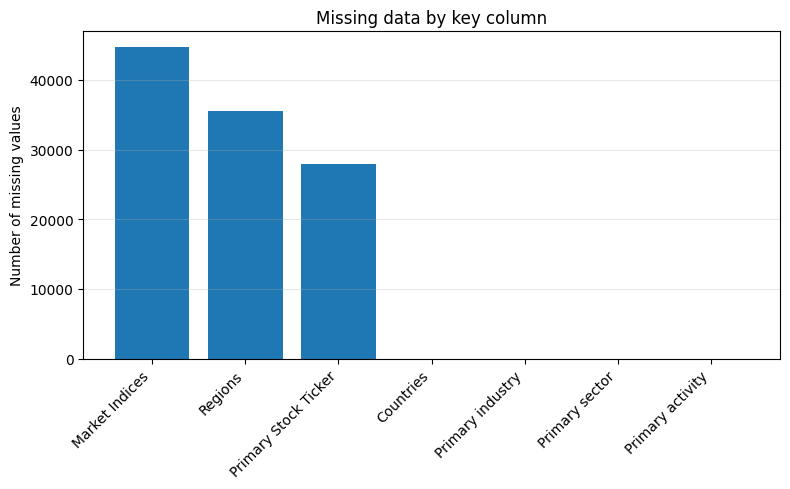

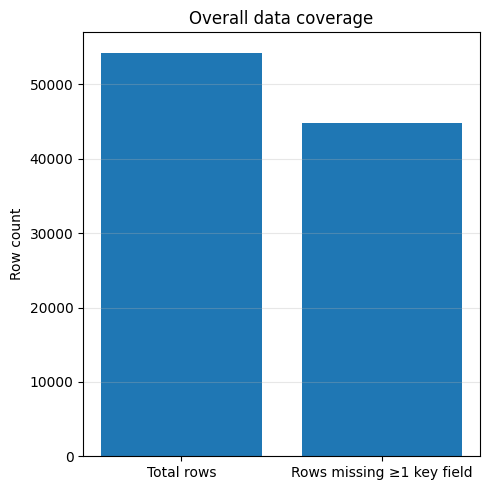

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------ CONFIG ------------
# DataFrame name you built earlier
DF_NAME = "df_accounts"   # change here if your variable is named differently

# Key columns to track missingness
KEY_COLUMNS = [
    "Primary industry",
    "Primary sector",
    "Primary activity",
    "Countries",
    "Regions",
    "Primary Stock Ticker",
    "Market Indices",
]

# ------------ ACCESS THE DATAFRAME ------------
if DF_NAME not in globals():
    raise NameError(
        f"The DataFrame variable '{DF_NAME}' is not defined in this session. "
        "Load or create it first, then re‑run this cell."
    )
df = globals()[DF_NAME]

# ------------ METRICS ------------
total_rows = len(df)

# Missing counts for each key column
missing_counts = df[KEY_COLUMNS].isna().sum().sort_values(ascending=False)

# Rows missing *any* key field
rows_missing_any = df[KEY_COLUMNS].isna().any(axis=1).sum()

# ------------ PLOT 1: Missing values per column ------------
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(missing_counts.index, missing_counts.values)
ax1.set_ylabel("Number of missing values")
ax1.set_title("Missing data by key column")
ax1.set_xticklabels(missing_counts.index, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
plt.tight_layout()

# ------------ PLOT 2: Overall row coverage ------------
fig2, ax2 = plt.subplots(figsize=(5, 5))
ax2.bar(["Total rows", "Rows missing ≥1 key field"], [total_rows, rows_missing_any])
ax2.set_ylabel("Row count")
ax2.set_title("Overall data coverage")
ax2.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()


# Filling Missing Industry Metadata Using External JSON Reference

This script enriches a DataFrame (`Scope_3_df`) by filling in missing metadata fields—specifically 'Primary industry,' 'Primary sector,' and 'Primary activity'—using information stored in an external JSON file (`account_dictionary.json`). It defines a function that matches each row’s account number and year to entries in the JSON file. If a match is found and the relevant field is missing (`NaN`), the missing value is populated from the corresponding JSON entry. The function is applied row-by-row across the DataFrame. Finally, the script reports how many of the missing values were successfully filled for each targeted field, aiding in data quality improvement for downstream analysis.


In [43]:
import json
import pandas as pd
import numpy as np

# Read the JSON file
json_path = r"C:\Users\cliff\OneDrive\Documents\Data Practicum1\CDP_Data\Corporate_Data\account_dictionary.json"
with open(json_path, 'r', encoding='utf-8-sig') as f:
    account_dict = json.load(f)

# Define a function to update a row based on the JSON lookup
def fill_missing_fields(row):
    # Convert account number and year to string for key lookup
    account = str(row['Account Numbers'])
    year = str(row['Year of Data'])
    
    # Check if there is matching information in the JSON dictionary
    if account in account_dict and year in account_dict[account]:
        info = account_dict[account][year]
        # Fill missing values only if they are NaN
        if pd.isna(row['Primary industry']) and 'Primary industry' in info:
            row['Primary industry'] = info['Primary industry']
        if pd.isna(row['Primary sector']) and 'Primary sector' in info:
            row['Primary sector'] = info['Primary sector']
        if pd.isna(row['Primary activity']) and 'Primary activity' in info:
            row['Primary activity'] = info['Primary activity']
    return row

# Assuming Scope_3_df is your DataFrame, apply the function row-wise
Scope_3_df = Scope_3_df.apply(fill_missing_fields, axis=1)

# Optionally, if you want to check how many values were filled:
filled_industry = Scope_3_df['Primary industry'].notna().sum()
filled_sector   = Scope_3_df['Primary sector'].notna().sum()
filled_activity = Scope_3_df['Primary activity'].notna().sum()

print("Filled Primary industry count:", filled_industry)
print("Filled Primary sector count:", filled_sector)
print("Filled Primary activity count:", filled_activity)


Filled Primary industry count: 914339
Filled Primary sector count: 914339
Filled Primary activity count: 914339


In [44]:
print(Scope_3_df.columns.tolist())


['Year of Data', 'Primary activity', 'Primary sector', 'Primary industry', 'Account Numbers', 'Countries', 'Company Name', 'Primary Stock Ticker', 'Row_num', 'Scope 3 Sources', 'Evaluation Status', 'Scope 3 Amount', 'Calculation Methodology', 'Perc emissions calculated w primary data ', 'Explanation']


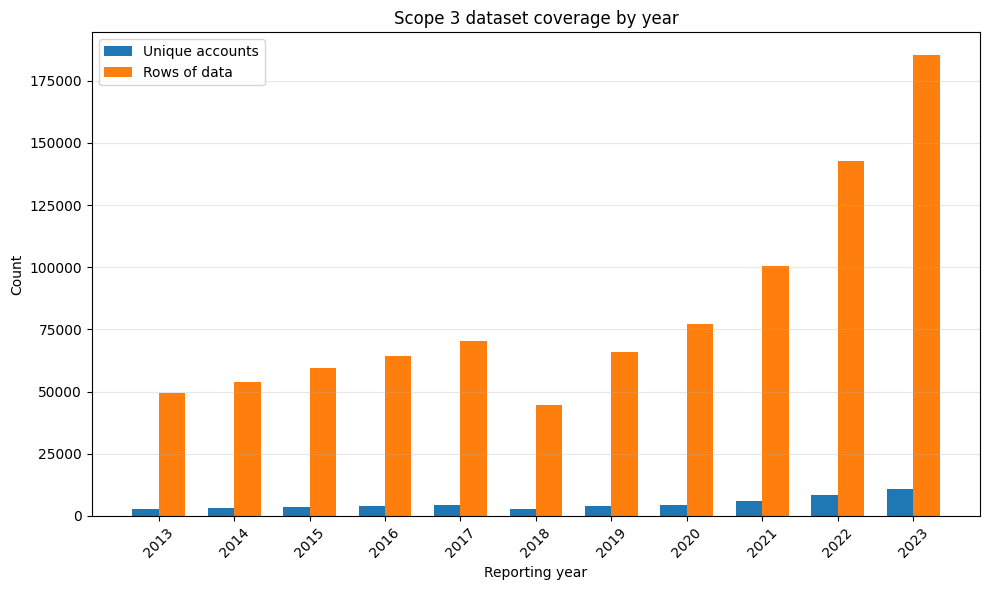

In [45]:
import matplotlib.pyplot as plt

# ----- column aliases for the new header names -----
YEAR_COL    = "Year of Data"
ACCOUNT_COL = "Account Numbers"

# --------- safety checks (fail fast with clear messages) ----------
if "Scope_3_df" not in globals():
    raise NameError(
        "Scope_3_df is not in memory. Load or create it first, then run this cell."
    )

missing_cols = {YEAR_COL, ACCOUNT_COL} - set(Scope_3_df.columns)
if missing_cols:
    raise KeyError(
        f"Expected columns not found in Scope_3_df: {', '.join(missing_cols)}"
    )

# --------- aggregate: unique accounts & total rows by year ----------
accounts_per_year = (
    Scope_3_df.groupby(YEAR_COL)[ACCOUNT_COL]
              .nunique()
              .sort_index()
)
rows_per_year = (
    Scope_3_df.groupby(YEAR_COL)
              .size()
              .sort_index()
)

years = accounts_per_year.index.astype(str)
bar_width = 0.35
indices   = range(len(years))

# ------------------ plot ------------------
fig, ax = plt.subplots(figsize=(10, 6))

# unique‑account bars (left)
ax.bar(
    [i - bar_width / 2 for i in indices],
    accounts_per_year.values,
    bar_width,
    label="Unique accounts",
)

# row‑count bars (right)
ax.bar(
    [i + bar_width / 2 for i in indices],
    rows_per_year.values,
    bar_width,
    label="Rows of data",
)

ax.set_xlabel("Reporting year")
ax.set_ylabel("Count")
ax.set_title("Scope 3 dataset coverage by year")
ax.set_xticks(list(indices))
ax.set_xticklabels(years, rotation=45)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [46]:
Scope_3_df.head()

,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation
0,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...
1,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...
2,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not includ...,"Not relevant, explanation provided",NaN,NaN,NaN,We do not have any fuel or energy related acti...
3,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",NaN,NaN,NaN,NaN
4,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN


In [47]:
# Define the desired order for the specified columns
cols_order = ['Account Numbers', 'Year of Data', 'Company Name', 'Primary Stock Ticker', 'Countries', 
             'Primary industry', 'Primary sector', 'Primary activity', 'Row_num','Scope 3 Sources', 'Scope 3 Amount', 'Evaluation Status', 'Calculation Methodology', 'Perc emissions calculated w primary data', 'Explanation']

# Create a list of desired columns that exist in merged_df2
existing_cols = [col for col in cols_order if col in Scope_3_df.columns]

# Identify the remaining columns that aren't in the desired list
remaining_cols = [col for col in Scope_3_df.columns if col not in existing_cols]



# Create a mask where 'Scope 3 Amount' is null AND 'Evaluation Status' is 'Not relevant, explanation provided'
mask = Scope_3_df['Scope 3 Amount'].isna() & (Scope_3_df['Evaluation Status'] == 'Not relevant, explanation provided')

# Assign 0 to 'Scope 3 Amount' where the mask is True
Scope_3_df.loc[mask, 'Scope 3 Amount'] = 0

print("Number of null values in 'Scope 3 Amount':", Scope_3_df['Scope 3 Amount'].isna().sum())

Scope_3_df.head(20)



Number of null values in 'Scope 3 Amount': 218432


,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation
0,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...
1,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...
2,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not includ...,"Not relevant, explanation provided",0,NaN,NaN,We do not have any fuel or energy related acti...
3,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",0,NaN,NaN,NaN
4,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN
5,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,6,Business travel,"Relevant, calculated",56.78,Defra 2012,NaN,NaN
6,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,7,Employee commuting,"Not relevant, explanation provided",0,NaN,NaN,Our employees commute into central London usin...
7,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,8,Upstream leased assets,Not evaluated,NaN,NaN,NaN,"We have not evaluated up-stream assets, and at..."
8,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,9,Investments,"Not relevant, calculated",NaN,NaN,NaN,We plan to investigate what steps can be taken to
9,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,10,Downstream transportation and distribution,"Not relevant, explanation provided",0,NaN,NaN,We are not involved in transoprt andf distribu...


In [48]:
import json
import numpy as np
import pandas as pd

# Load the dictionary from the JSON file
with open(r'C:\Users\cliff\OneDrive\Documents\Data Practicum1\CDP_Data\Corporate_Data\combined_scope_1_2.json', 'r', encoding='utf-8-sig') as f:
    scope_1_2_dict = json.load(f)

# Function to create the key and return the corresponding emission value
def get_scope_1_2_total_emission(row):
    key = f"{row['Account Numbers']}_{row['Year of Data']}"
    return scope_1_2_dict.get(key, np.nan)


Scope_3_df['Scope 1 2 total emission'] = Scope_3_df.apply(get_scope_1_2_total_emission, axis=1)

Scope_3_df.head(20)


,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation,Scope 1 2 total emission
0,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...,406.35
1,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...,406.35
2,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not includ...,"Not relevant, explanation provided",0,NaN,NaN,We do not have any fuel or energy related acti...,406.35
3,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",0,NaN,NaN,NaN,406.35
4,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN,406.35
5,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,6,Business travel,"Relevant, calculated",56.78,Defra 2012,NaN,NaN,406.35
6,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,7,Employee commuting,"Not relevant, explanation provided",0,NaN,NaN,Our employees commute into central London usin...,406.35
7,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,8,Upstream leased assets,Not evaluated,NaN,NaN,NaN,"We have not evaluated up-stream assets, and at...",406.35
8,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,9,Investments,"Not relevant, calculated",NaN,NaN,NaN,We plan to investigate what steps can be taken to,406.35
9,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,10,Downstream transportation and distribution,"Not relevant, explanation provided",0,NaN,NaN,We are not involved in transoprt andf distribu...,406.35


In [49]:
Scope_3_df['Scope 1 2 max'] = Scope_3_df.groupby(
    ['Primary activity', 'Primary sector', 'Primary industry', 'Scope 3 Sources']
)['Scope 1 2 total emission'].transform('max')

Scope_3_df['Scope 1 2 Normalized'] = Scope_3_df['Scope 1 2 total emission']  / Scope_3_df['Scope 1 2 max'] 

import numpy as np


# Ensure 'Scope 3 Amount' is numeric; non-numeric values become NaN
Scope_3_df['Scope 3 Amount'] = pd.to_numeric(Scope_3_df['Scope 3 Amount'], errors='coerce')

# Compute the group maximum for 'Scope 3 Amount'
group_max = Scope_3_df.groupby(
    ['Primary activity', 'Primary sector', 'Primary industry', 'Scope 3 Sources']
)['Scope 3 Amount'].transform('max')

# Create 'Scope 3 max': if 'Scope 3 Amount' is null, then 'Scope 3 max' should also be null.
Scope_3_df['Scope 3 max'] = np.where(Scope_3_df['Scope 3 Amount'].isnull(), np.nan, group_max)


def calculate_scope_3_estimate(row):
    # If 'Scope 3 max' is null, then estimate is 0
    if pd.isnull(row['Scope 3 max']):
        return 0
    # Otherwise, calculate the product
    estimate = row['Scope 1 2 Normalized'] * row['Scope 3 max']
    # If the product is less than 1, set it to 0
    return 0 if estimate < 1 else estimate

# Apply the function to each row to create the new column
Scope_3_df['Scope 3 estimate'] = Scope_3_df.apply(calculate_scope_3_estimate, axis=1)

Scope_3_df['Scope 3 Amount or Estimate'] = Scope_3_df['Scope 3 Amount'].fillna(Scope_3_df['Scope 3 estimate'])


Scope_3_df.head(5)

,Year of Data,Primary activity,Primary sector,Primary industry,Account Numbers,Countries,Company Name,Primary Stock Ticker,Row_num,Scope 3 Sources,Evaluation Status,Scope 3 Amount,Calculation Methodology,Perc emissions calculated w primary data,Explanation,Scope 1 2 total emission,Scope 1 2 max,Scope 1 2 Normalized,Scope 3 max,Scope 3 estimate,Scope 3 Amount or Estimate
0,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,1,Purchased goods and services,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...,406.35,4.186718e+10,9.705693e-09,NaN,0.0,0.00
1,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,2,Capital goods,Not evaluated,NaN,NaN,NaN,We do not have access to this data at this poi...,406.35,4.186718e+10,9.705693e-09,NaN,0.0,0.00
2,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,3,Fuel-and-energy-related activities (not includ...,"Not relevant, explanation provided",0.00,NaN,NaN,We do not have any fuel or energy related acti...,406.35,4.186718e+10,9.705693e-09,311341.00,0.0,0.00
3,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,4,Upstream transportation and distribution,"Not relevant, explanation provided",0.00,NaN,NaN,NaN,406.35,4.186718e+10,9.705693e-09,1361260.00,0.0,0.00
4,2013,Asset managers,Financial services,Services,44,United Kingdom,3i Group,III LN,5,Waste generated in operations,"Relevant, calculated",12.34,Defra 2012,NaN,NaN,406.35,4.186718e+10,9.705693e-09,173925.26,0.0,12.34


# Fix Redundant Country Names

In [50]:
# Dictionary mapping duplicate country names to standardized names
country_mapping = {
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "United States of America": "USA",
    "Taiwan, Greater China": "Taiwan",
    "Taiwan, China": "Taiwan",
    "Republic of Korea": "South Korea",
    "Russian Federation": "Russia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Czechia": "Czech Republic",
    "Viet Nam": "Vietnam"
}

# Replace duplicate values in the 'Countries' column of Scope_3_df
Scope_3_df["Countries"] = Scope_3_df["Countries"].replace(country_mapping)


# Get Country Data counts

In [51]:
# Filter for the year 2013
df_2013 = Scope_3_df[Scope_3_df['Year of Data'] == '2013']

# Group by 'Countries' and sum the 'Scope 3 Amount'
country_totals = df_2013.groupby('Countries')['Scope 3 Amount or Estimate'].sum()

# Sort the result in descending order
country_totals_sorted = country_totals.sort_values(ascending=False)

print(country_totals_sorted)


Countries
USA               2.945148e+09
United Kingdom    2.285857e+09
France            1.847320e+09
Japan             1.731273e+09
Spain             1.441149e+09
                      ...     
Guatemala         0.000000e+00
Jordan            0.000000e+00
Liechtenstein     0.000000e+00
Nigeria           0.000000e+00
Egypt             0.000000e+00
Name: Scope 3 Amount or Estimate, Length: 67, dtype: float64


In [52]:
# Filter for rows with 'Countries' as 'USA' and 'Year of Data' as '2013'
df_filtered = Scope_3_df[(Scope_3_df['Countries'] == 'USA') & (Scope_3_df['Year of Data'] == '2013')]

# Group by 'Scope 3 Sources' and sum 'Scope 3 Amount or Estimate'
totals_by_source = df_filtered.groupby('Scope 3 Sources')['Scope 3 Amount or Estimate'].sum()

# Sort the results in descending order
totals_by_source_sorted = totals_by_source.sort_values(ascending=False)

print(totals_by_source_sorted)


Scope 3 Sources
Use of sold products                                                 1.768431e+09
Downstream transportation and distribution                           4.617869e+08
Purchased goods and services                                         2.838056e+08
Fuel-and-energy-related activities (not included in Scope 1 or 2)    2.134615e+08
Upstream transportation and distribution                             8.327461e+07
End of life treatment of sold products                               3.779679e+07
Processing of sold products                                          2.060144e+07
Investments                                                          1.326378e+07
Business travel                                                      1.227796e+07
Other (downstream)                                                   1.141436e+07
Other (upstream)                                                     8.303121e+06
Employee commuting                                                   8.272337e+06
